In [1]:
import os
import shutil

# Paths
original_path = r"D:\CIP_MRI\AugmentedAlzheimerDataset"
output_path = r"D:\CIP_MRI\ReorganizedAlzheimerDataset"

# Mapping from original to new classes
class_map = {
    "NonDemented": "CN",
    "MildDemented": "MCI",
    "ModerateDemented": "AD"
}

# Create destination folders
for label in class_map.values():
    os.makedirs(os.path.join(output_path, label), exist_ok=True)

# Copy files to new structure
for folder in os.listdir(original_path):
    if folder not in class_map:
        print(f"Skipping folder: {folder}")
        continue

    class_label = class_map[folder]
    src_folder = os.path.join(original_path, folder)
    dest_folder = os.path.join(output_path, class_label)

    for file in os.listdir(src_folder):
        src_file = os.path.join(src_folder, file)
        dest_file = os.path.join(dest_folder, file)
        shutil.copy(src_file, dest_file)

print("✅ Dataset reorganized into CN, AD, and MCI.")


Skipping folder: VeryMildDemented
✅ Dataset reorganized into CN, AD, and MCI.


In [3]:
import os

# Path to the reorganized dataset
dataset_path = r"D:\CIP_MRI\ReorganizedAlzheimerDataset"

# Count images in each class
for label in ["CN", "MCI", "AD"]:
    class_path = os.path.join(dataset_path, label)
    if os.path.exists(class_path):
        num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        print(f"{label}: {num_files} images")
    else:
        print(f"{label} folder not found!")


CN: 9600 images
MCI: 8960 images
AD: 6464 images


In [9]:
pip install torch==2.6.0 -i https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
     ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
     ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
     ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
     ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
     -------------------------------------- 0.5/204.1 MB 279.8 kB/s eta 0:12:08
     -------------------------------------- 0.5/204.1 MB 279.8 kB/s eta 0:12:08
     -------------------------------------- 0.5/204.1 MB 279.8 kB/s eta 0:12:08
     -------------------------------------- 0.5/204.1 MB 279.8 kB/s eta 0:12:08
     ------------------------------

In [11]:
import os
from PIL import Image
import numpy as np
import torch

# === Parameters ===
data_dir = r"D:\CIP_MRI\ReorganizedAlzheimerDataset"
image_size = 128

# === Manual transform function ===
def load_image(filepath):
    img = Image.open(filepath).convert('L')  # Convert to grayscale
    img = img.resize((image_size, image_size))
    img = np.array(img) / 255.0              # Normalize to [0, 1]
    img = (img - 0.5) / 0.5                   # Normalize to [-1, 1]
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dim: (1, H, W)
    return img

# === Scan dataset ===
classes = ['CN', 'MCI', 'AD']
data = []

for class_index, label in enumerate(classes):
    folder = os.path.join(data_dir, label)
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        img_tensor = load_image(filepath)
        data.append((img_tensor, class_index))

print(f"Loaded {len(data)} images.")


Loaded 25024 images.


In [13]:
import os

# Path to the reorganized dataset
dataset_path = r"D:\CIP_MRI\ReorganizedAlzheimerDataset"

# Count images in each class
for label in ["CN", "MCI", "AD"]:
    class_path = os.path.join(dataset_path, label)
    if os.path.exists(class_path):
        num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        print(f"{label}: {num_files} images")
    else:
        print(f"{label} folder not found!")


CN: 9600 images
MCI: 8960 images
AD: 6464 images


In [15]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------------
# CONFIGURATION
# -------------------------
input_dir = r"D:\CIP_MRI\ReorganizedAlzheimerDataset"         # Original preprocessed MRI images folder
output_dir = r"D:\CIP_MRI\balanced_data"   # Where balanced images will be stored
target_count = 9600                                      # Set target to CN's count (or another desired number)

# Augmentation settings (feel free to adjust)
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

# -------------------------
# UTILITY FUNCTIONS
# -------------------------
def get_all_image_paths(folder):
    """Recursively find all image paths (png, jpg, jpeg) under folder."""
    image_paths = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

def copy_originals(class_in_path, class_out_path):
    """Copy all original images from class_in_path (recursively) to class_out_path."""
    os.makedirs(class_out_path, exist_ok=True)
    image_paths = get_all_image_paths(class_in_path)
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        out_path = os.path.join(class_out_path, filename)
        if not os.path.exists(out_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                cv2.imwrite(out_path, img)
    return get_all_image_paths(class_out_path)  # return list of copied image paths

# -------------------------
# MAIN PROCESS: For Each Class (CN, MCI, AD)
# -------------------------
classes = ["CN", "MCI", "AD"]

for cls in classes:
    print(f"\nProcessing class: {cls}")
    
    # Define folder paths for this class
    class_input_path = os.path.join(input_dir, cls)
    class_output_path = os.path.join(output_dir, cls)
    os.makedirs(class_output_path, exist_ok=True)
    
    # Copy originals to output folder
    original_images = copy_originals(class_input_path, class_output_path)
    original_count = len(original_images)
    print(f"  Original images copied for {cls}: {original_count}")
    
    # Determine how many augmented images we need
    current_count = len(get_all_image_paths(class_output_path))
    required = target_count - current_count
    print(f"  {cls}: {current_count} images in output, need {required} augmented images.")
    
    if required <= 0:
        print(f"  No augmentation needed for {cls}.")
        continue

    generated = 0
    # For each original image, generate augmented versions until we meet the requirement
    for img_path in original_images:
        if generated >= required:
            break
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"  ❌ Skipping {img_path} (cannot read)")
            continue

        # Prepare image for augmentation: add channel & batch dimensions
        img_array = np.expand_dims(img, axis=-1)  # shape: (H, W, 1)
        img_array = np.expand_dims(img_array, axis=0)  # shape: (1, H, W, 1)
        
        # Generate augmented images from this image
        aug_iter = datagen.flow(img_array, batch_size=1, shuffle=False)
        while generated < required:
            aug_img = next(aug_iter)[0]
            aug_img_uint8 = (np.clip(aug_img, 0, 1) * 255).astype(np.uint8).squeeze()
            new_filename = f"aug_{generated}_" + os.path.basename(img_path).split('.')[0] + ".png"
            save_path = os.path.join(class_output_path, new_filename)
            cv2.imwrite(save_path, aug_img_uint8)
            generated += 1
            if generated % 10 == 0:
                print(f"  {cls}: Generated {generated}/{required} augmented images...")
            # Optionally, limit number per original image
            # break after generating, e.g., 3 images per original if needed

    total_after = len(get_all_image_paths(class_output_path))
    print(f"  {cls}: Augmentation complete. Total images now: {total_after}")

print("\n🎉 Data augmentation and balancing complete!")



Processing class: CN
  Original images copied for CN: 9600
  CN: 9600 images in output, need 0 augmented images.
  No augmentation needed for CN.

Processing class: MCI
  Original images copied for MCI: 8960
  MCI: 8960 images in output, need 640 augmented images.
  MCI: Generated 10/640 augmented images...
  MCI: Generated 20/640 augmented images...
  MCI: Generated 30/640 augmented images...
  MCI: Generated 40/640 augmented images...
  MCI: Generated 50/640 augmented images...
  MCI: Generated 60/640 augmented images...
  MCI: Generated 70/640 augmented images...
  MCI: Generated 80/640 augmented images...
  MCI: Generated 90/640 augmented images...
  MCI: Generated 100/640 augmented images...
  MCI: Generated 110/640 augmented images...
  MCI: Generated 120/640 augmented images...
  MCI: Generated 130/640 augmented images...
  MCI: Generated 140/640 augmented images...
  MCI: Generated 150/640 augmented images...
  MCI: Generated 160/640 augmented images...
  MCI: Generated 170/64

In [19]:
import os

# Path to the reorganized dataset
dataset_path = r"D:\CIP_MRI\balanced_data"

# Count images in each class
for label in ["CN", "MCI", "AD"]:
    class_path = os.path.join(dataset_path, label)
    if os.path.exists(class_path):
        num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        print(f"{label}: {num_files} images")
    else:
        print(f"{label} folder not found!")


CN: 9600 images
MCI: 9600 images
AD: 9600 images


In [21]:
import os
import shutil
import random

# Set paths
input_dir = "D:/CIP_MRI/balanced_data"  # Update with your actual dataset path
output_dir = "D:/CIP_MRI/split"  # The output path for the split dataset

# Train/Val/Test split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Categories
categories = ["CN", "MCI", "AD"]

# Create output directories for each split and category
for split in ["train", "val", "test"]:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Function to split the dataset into Train, Validation, and Test sets
def split_data():
    for category in categories:
        category_path = os.path.join(input_dir, category)
        images = os.listdir(category_path)
        random.shuffle(images)  # Shuffle the images for randomness

        # Split the dataset
        train_count = int(len(images) * train_ratio)
        val_count = int(len(images) * val_ratio)

        # Assign images to splits
        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        # Move images to respective directories
        for img in train_images:
            shutil.move(os.path.join(category_path, img), os.path.join(output_dir, "train", category, img))

        for img in val_images:
            shutil.move(os.path.join(category_path, img), os.path.join(output_dir, "val", category, img))

        for img in test_images:
            shutil.move(os.path.join(category_path, img), os.path.join(output_dir, "test", category, img))

        print(f"✅ {category}: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

# Run the data split function
split_data()
print("🎯 MRI dataset successfully split into Train/Val/Test sets!")


✅ CN: Train=7680, Val=960, Test=960
✅ MCI: Train=7680, Val=960, Test=960
✅ AD: Train=7680, Val=960, Test=960
🎯 MRI dataset successfully split into Train/Val/Test sets!


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
img_height, img_width = 224, 224  # adjust based on your model
batch_size = 32

train_dir = "D:/CIP_MRI/split/train"
val_dir = "D:/CIP_MRI/split/val"
test_dir = "D:/CIP_MRI/split/test"

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 23040 images belonging to 3 classes.
Found 2880 images belonging to 3 classes.
Found 2880 images belonging to 3 classes.


In [32]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# -------------------------------
# Configuration
# -------------------------------
train_dir = "D:/CIP_MRI/split/train"
val_dir = "D:/CIP_MRI/split/val"
test_dir = "D:/CIP_MRI/split/test"
img_height, img_width = 224, 224
batch_size = 32
epochs = 20
num_classes = 3

# -------------------------------
# Data Generators
# -------------------------------
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -------------------------------
# Model Architecture
# -------------------------------
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# -------------------------------
# Train the Model
# -------------------------------
checkpoint = ModelCheckpoint("best_mri_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint]
)

# -------------------------------
# Evaluate the Model
# -------------------------------
loss, acc = model.evaluate(test_generator)
print(f"🎯 Final Test Accuracy: {acc * 100:.2f}%")

# -------------------------------
# Save the Final Model
# -------------------------------
model.save("MRI_Model.h5")


Found 23040 images belonging to 3 classes.
Found 2880 images belonging to 3 classes.
Found 2880 images belonging to 3 classes.


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6667 - loss: 0.8074
Epoch 1: val_accuracy improved from -inf to 0.90278, saving model to best_mri_model.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1049s 1s/step - accuracy: 0.6668 - loss: 0.8070 - val_accuracy: 0.9028 - val_loss: 0.2487
Epoch 2/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8949 - loss: 0.2586
Epoch 2: val_accuracy improved from 0.90278 to 0.90868, saving model to best_mri_model.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1058s 1s/step - accuracy: 0.8949 - loss: 0.2586 - val_accuracy: 0.9087 - val_loss: 0.2265
Epoch 3/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9311 - loss: 0.1804
Epoch 3: val_accuracy improved from 0.90868 to 0.93333, saving model to best_mri_model.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1044s 1s/step - accuracy: 0.9311 - loss: 0.1804 - val_accuracy: 0.9333 - val_loss: 0.1623
Epoch 4/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9543 - loss: 0.1181
Epoch 4: val_accuracy improved from 0.93333 to 0.93924, saving model to best_mri_model.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 953s 1s/step - accuracy: 0.9543 - loss: 0.1181 - val_accuracy: 0.9392 - val_loss: 0.1580
Epoch 5/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9617 - loss: 0.0974
Epoch 5: val_accuracy improved from 0.93924 to 0.93993, saving model to best_mri_model.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1009s 1s/step - accuracy: 0.9617 - loss: 0.0974 - val_accuracy: 0.9399 - val_loss: 0.1509
Epoch 6/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9690 - loss: 0.0802
Epoch 6: val_accuracy improved from 0.93993 to 0.94861, saving model to best_mri_model.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 1234s 2s/step - accuracy: 0.9690 - loss: 0.0802 - val_accuracy: 0.9486 - val_loss: 0.1510
Epoch 7/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9774 - loss: 0.0611
Epoch 7: val_accuracy did not improve from 0.94861
720/720 ━━━━━━━━━━━━━━━━━━━━ 1186s 2s/step - accuracy: 0.9774 - loss: 0.0611 - val_accuracy: 0.9451 - val_loss: 0.1810
Epoch 8/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9795 - loss: 0.0547
Epoch 8: val_accuracy did not improve from 0.94861
720/720 ━━━━━━━━━━━━━━━━━━━━ 987s 1s/step - accuracy: 0.9795 - loss: 0.0547 - val_accuracy: 0.9427 - val_loss: 0.1886
Epoch 9/20



KeyboardInterrupt



In [36]:
model.save("D:/CIP_MRI/MRI_Model.h5")

90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 462ms/step

Classification Report:
              precision    recall  f1-score   support

          AD       0.98      1.00      0.99       960
          CN       0.93      0.93      0.93       960
         MCI       0.93      0.91      0.92       960

    accuracy                           0.95      2880
   macro avg       0.95      0.95      0.95      2880
weighted avg       0.95      0.95      0.95      2880



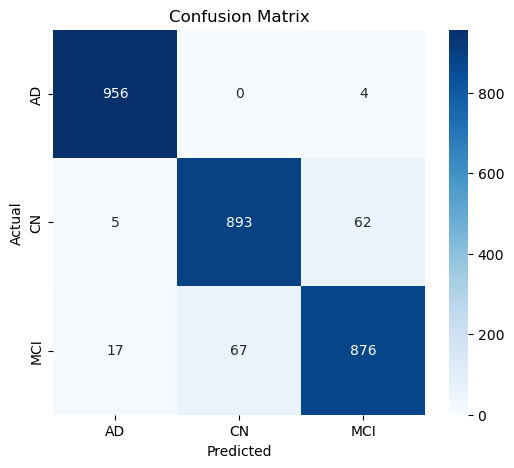

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step


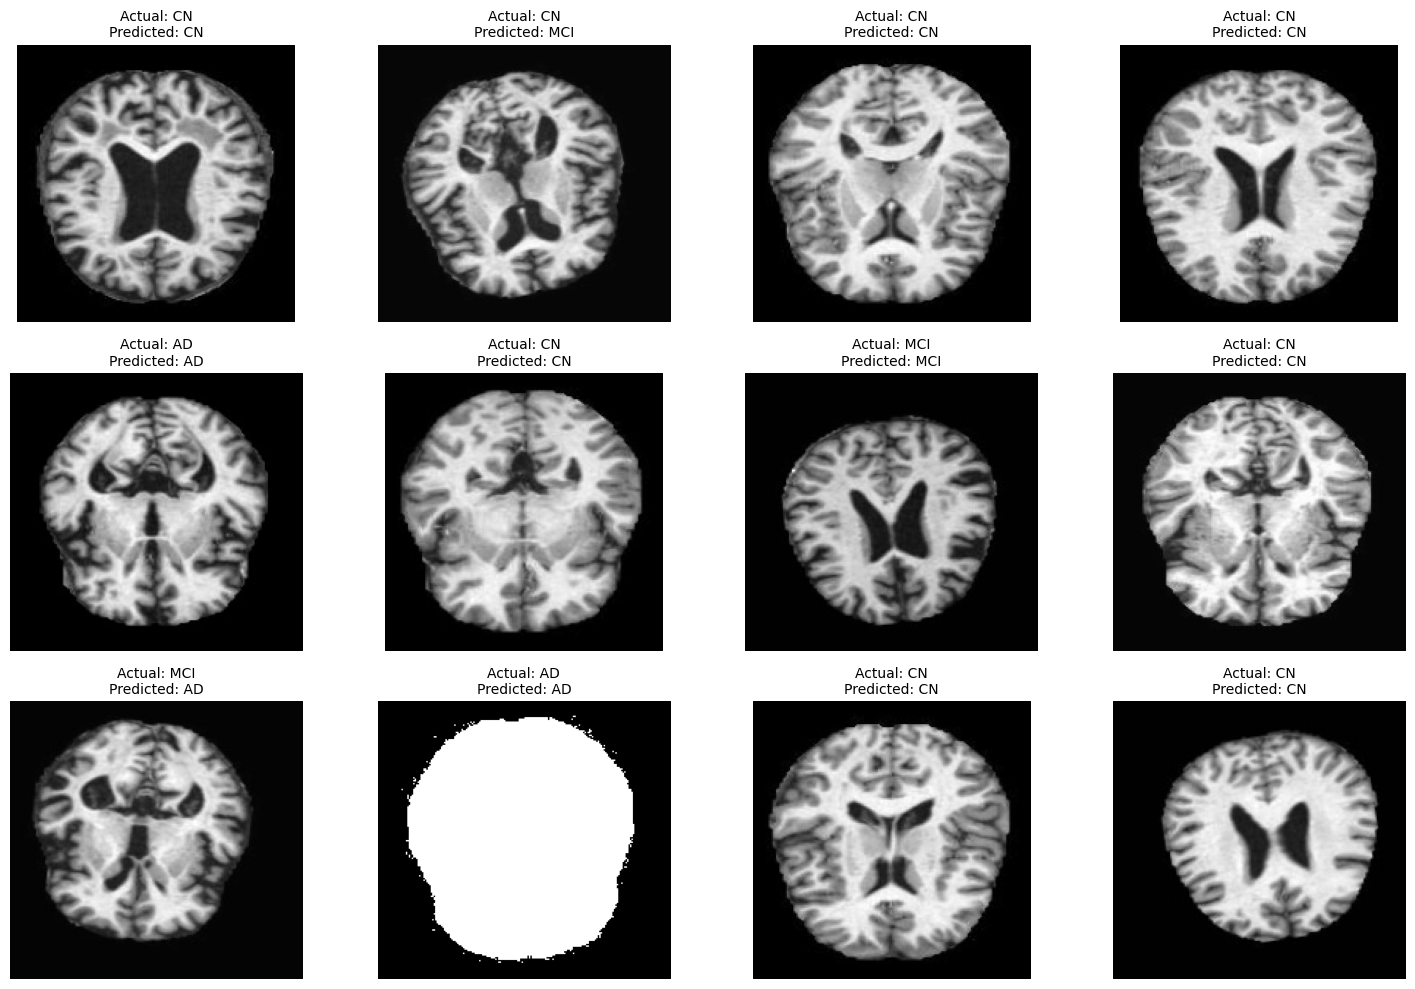

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Make predictions
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Get file paths of test images
file_paths = test_generator.filepaths

# Display a few random test images with actual vs predicted labels
num_images = 12  # Number of examples to show
plt.figure(figsize=(15, 10))

for i in range(num_images):
    index = random.randint(0, len(file_paths) - 1)
    img = plt.imread(file_paths[index])
    true_label = class_labels[y_true[index]]
    predicted_label = class_labels[y_pred[index]]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Actual: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
